In [1]:
!pip install yelpapi
!pip install numpy
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


In [2]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [3]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['Yolo County, California',
 'Clearwater County, Idaho',
 'Madison County, Illinois',
 'Grundy County, Iowa',
 'Chambers County, Texas',
 'Fisher County, Texas',
 'Crittenden County, Arkansas',
 'Dinwiddie County, Virginia',
 'Coos County, New Hampshire',
 'Potter County, Pennsylvania']

In [4]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price"])
res_df

,name,zipcode,county_string,rating,review_count,category,price


In [5]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American (Traditional)","American (New)","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"])==str(term)) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                                    
                                    print("\n",responsejson["businesses"][x]["name"],
                                        responsejson["businesses"][x]["location"]["zip_code"],
                                        zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        responsejson["businesses"][x]["categories"][y]["title"])
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                        str(zc),
                                        county_string,
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        term,
                                        responsejson["businesses"][x]["price"]]
                                    count += 1
                                    r += 1
                except:
                    
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            print("Error: this shouldn't happen")
            break



 Osteria Fasulo 95616 Yolo County, California 4.0 191 Italian

 Guinevere's Cafe & Bistro 95695 Yolo County, California 4.5 116 Italian

 Paesanos 95616 Yolo County, California 3.5 443 Italian
End of list. Found 3 Italian restaurants in Yolo County, California

 Vince's Ristorante 95691 Yolo County, California 3.5 199 Italian

 Steve's Pizza 95616 Yolo County, California 3.5 150 Italian
End of list. Found 2 Italian restaurants in Yolo County, California

 La Plazita Taqueria 95653 Yolo County, California 4.5 30 Mexican

 Taqueria Guadalajara 95616 Yolo County, California 4.0 602 Mexican

 Taqueria Davis 95616 Yolo County, California 4.5 471 Mexican

 Chuy's Taqueria 95694 Yolo County, California 3.5 77 Mexican

 El Pueblo Meat Market & Deli 95694 Yolo County, California 4.0 50 Mexican

 Las Brasas Tacos & Salsas 95695 Yolo County, California 4.0 168 Mexican

 Davis's Piñata Mexican Grill 95616 Yolo County, California 4.0 139 Mexican

 Taqueria Guadalajara Grill 95616 Yolo County, Cali


 Si Senor Mex Mex Grill 62040 Madison County, Illinois 3.0 10 Mexican

 El Torero Family Mexican Restaurant 62040 Madison County, Illinois 3.0 13 Mexican

 Don Ole Mexican Restaurant 62249 Madison County, Illinois 2.5 12 Mexican

 Bert's Chuckwagon 62234 Madison County, Illinois 4.0 37 Mexican

 Orient 62025 Madison County, Illinois 4.0 23 Chinese

 Shangri-La 62025 Madison County, Illinois 4.0 34 Chinese

 New China 62010 Madison County, Illinois 4.0 14 Chinese

 Orient Wok Chop Suey 62025 Madison County, Illinois 4.0 8 Chinese

 Peking Garden 62234 Madison County, Illinois 4.0 29 Chinese

 88 China 62040 Madison County, Illinois 4.0 61 Chinese

 Asia Garden 62234 Madison County, Illinois 4.0 45 Chinese

 Jade Garden 62062 Madison County, Illinois 3.5 18 Chinese

 Vin Hoa 62040 Madison County, Illinois 4.5 15 Chinese

 China Wok 62035 Madison County, Illinois 4.0 11 Chinese

 Best Buffet 62095 Madison County, Illinois 3.5 6 Chinese

 China King 62025 Madison County, Illinois 2.5 8 Ch


 Original Italian Pizza 16915 Potter County, Pennsylvania 3.5 7 Italian
End of list. Found 1 Italian restaurants in Potter County, Pennsylvania

 China Garden 16915 Potter County, Pennsylvania 3.0 6 Chinese

 Sweden Valley inn 16915 Potter County, Pennsylvania 4.5 11 American (Traditional)

 The Hotel Crittenden 16915 Potter County, Pennsylvania 4.0 18 American (Traditional)

 Olga Gallery, Cafe, & Bistro 16915 Potter County, Pennsylvania 4.5 27 American (Traditional)

 The Costello Inn 16720 Potter County, Pennsylvania 4.0 4 American (Traditional)

 Debs Cross Fork Inn 17729 Potter County, Pennsylvania 5.0 3 American (New)


In [6]:
res_df.to_csv("output1804071028.csv")
try:
    res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
except:
    print("Already done")
try:
    res_df.category.replace(["American (New)","American (Traditional)"],["American","American"],inplace=True)
except:
    print("Already done")
res_df


,name,zipcode,county_string,rating,review_count,category,price
0,Osteria Fasulo,95616,"Yolo County, California",4.0,191,Italian,3
1,Guinevere's Cafe & Bistro,95695,"Yolo County, California",4.5,116,Italian,2
2,Paesanos,95616,"Yolo County, California",3.5,443,Italian,2
3,Vince's Ristorante,95691,"Yolo County, California",3.5,199,Italian,2
4,Steve's Pizza,95616,"Yolo County, California",3.5,150,Italian,2
5,La Plazita Taqueria,95653,"Yolo County, California",4.5,30,Mexican,1
6,Taqueria Guadalajara,95616,"Yolo County, California",4.0,602,Mexican,1
7,Taqueria Davis,95616,"Yolo County, California",4.5,471,Mexican,1
8,Chuy's Taqueria,95694,"Yolo County, California",3.5,77,Mexican,1
9,El Pueblo Meat Market & Deli,95694,"Yolo County, California",4.0,50,Mexican,1


In [7]:
itadf = res_df.groupby(res_df["category"]).get_group("Italian")
mexdf = res_df.groupby(res_df["category"]).get_group("Mexican")
chndf = res_df.groupby(res_df["category"]).get_group("Chinese")
usadf = res_df.groupby(res_df["category"]).get_group("American")
inddf = res_df.groupby(res_df["category"]).get_group("Indian")
res_df
# CHA = res_df.groupby(res_df["county_string"]).get_group("Mecklenburg County, North Carolina")
# CHAbreakdown = pd.DataFrame(CHA["category"].value_counts()).T.reset_index()
# CHAbreakdown["county_string"]="Mecklenburg County, North Carolina"
# CHA_price_avg = CHA.groupby(res_df["price"]).mean()
# CHA_price_count = CHA["price"].value_counts()

# RAL = res_df.groupby(res_df["county_string"]).get_group("Wake County, North Carolina")
# RALbreakdown = pd.DataFrame(RAL["category"].value_counts()).T.reset_index()
# RALbreakdown["county_string"]="Wake County, North Carolina"
# RAL_price_avg = RAL.groupby(res_df["price"]).mean()
# RAL_price_count = RAL["price"].value_counts()

# ATL = res_df.groupby(res_df["county_string"]).get_group("Fulton County, Georgia")
# ATLbreakdown = pd.DataFrame(ATL["category"].value_counts()).T.reset_index()
# ATLbreakdown["county_string"]="Fulton County, Georgia"
# ATL_price_avg = ATL.groupby(res_df["price"]).mean()
# ATL_price_count = ATL["price"].value_counts()

# MEM = res_df.groupby(res_df["county_string"]).get_group("Shelby County, Tennessee")
# MEMbreakdown = pd.DataFrame(MEM["category"].value_counts()).T.reset_index()
# MEMbreakdown["county_string"]="Shelby County, Tennessee"
# MEM_price_avg = MEM.groupby(res_df["price"]).mean()
# MEM_price_count = MEM["price"].value_counts()


# ORL = res_df.groupby(res_df["county_string"]).get_group("Orange County, Florida")
# ORLbreakdown = pd.DataFrame(ORL["category"].value_counts()).T.reset_index()
# ORLbreakdown["county_string"]="Orange County, Florida"
# ORL_price_avg = ORL.groupby(res_df["price"]).mean()
# ORL_price_count = ORL["price"].value_counts()

# MIL = res_df.groupby(res_df["county_string"]).get_group("Milwaukee County, Wisconsin")
# MILbreakdown = pd.DataFrame(MIL["category"].value_counts()).T.reset_index()
# MILbreakdown["county_string"]="Milwaukee County, Wisconsin"
# MIL_price_avg = MIL.groupby(res_df["price"]).mean()
# MIL_price_count = MIL["price"].value_counts()

# SFC = res_df.groupby(res_df["county_string"]).get_group("San Francisco County, California")
# SFCbreakdown = pd.DataFrame(SFC["category"].value_counts()).T.reset_index()
# SFCbreakdown["county_string"]="San Francisco County, California"
# SFC_price_avg = SFC.groupby(res_df["price"]).mean()
# SFC_price_count = SFC["price"].value_counts()

# AUS = res_df.groupby(res_df["county_string"]).get_group("Travis County, Texas")
# AUSbreakdown = pd.DataFrame(AUS["category"].value_counts()).T.reset_index()
# AUSbreakdown["county_string"]="Travis County, Texas"
# AUS_price_avg = AUS.groupby(res_df["price"]).mean()
# AUS_price_count = AUS["price"].value_counts()

# PIT = res_df.groupby(res_df["county_string"]).get_group("Allegheny County, Pennsylvania")
# PITbreakdown = pd.DataFrame(PIT["category"].value_counts()).T.reset_index()
# PITbreakdown["county_string"]="Allegheny County, Pennsylvania"
# PIT_price_avg = PIT.groupby(res_df["price"]).mean()
# PIT_price_count = PIT["price"].value_counts()


,name,zipcode,county_string,rating,review_count,category,price
0,Osteria Fasulo,95616,"Yolo County, California",4.0,191,Italian,3
1,Guinevere's Cafe & Bistro,95695,"Yolo County, California",4.5,116,Italian,2
2,Paesanos,95616,"Yolo County, California",3.5,443,Italian,2
3,Vince's Ristorante,95691,"Yolo County, California",3.5,199,Italian,2
4,Steve's Pizza,95616,"Yolo County, California",3.5,150,Italian,2
5,La Plazita Taqueria,95653,"Yolo County, California",4.5,30,Mexican,1
6,Taqueria Guadalajara,95616,"Yolo County, California",4.0,602,Mexican,1
7,Taqueria Davis,95616,"Yolo County, California",4.5,471,Mexican,1
8,Chuy's Taqueria,95694,"Yolo County, California",3.5,77,Mexican,1
9,El Pueblo Meat Market & Deli,95694,"Yolo County, California",4.0,50,Mexican,1


In [8]:
TOTAL_price_avg = res_df.groupby(["price"]).mean()
rescount = res_df.groupby(["county_string"]).count()["name"].reset_index()
rescount.columns=['county_string', 'restaurant_count']
TOTAL_county_reviews = res_df.groupby(["county_string"]).review_count.sum().reset_index()
TOTAL_county_reviews.columns=["county_string","review_count"]
TOTAL_county_avg = res_df.groupby(res_df["county_string"]).mean().reset_index()

county_stats = TOTAL_county_avg.merge(TOTAL_county_reviews, on="county_string")
csdf = county_stats.merge(counties, on="county_string")
c_df = rescount.merge(csdf, on="county_string")
c_df

,county_string,restaurant_count,rating,price,review_count,CensusId,State,County,TotalPop,Men,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,"Chambers County, Texas",2,3.500000,1.500000,15,48071,Texas,Chambers,37251,18691,...,2.2,2.4,31.0,15166,77.9,15.9,6.1,0.1,7.8,SW
1,"Clearwater County, Idaho",2,3.500000,2.000000,24,16035,Idaho,Clearwater,8560,4736,...,2.1,6.6,28.6,2877,65.5,23.3,10.2,0.9,7.3,WC
2,"Coos County, New Hampshire",7,3.571429,1.857143,97,33007,New Hampshire,Coos,31870,16226,...,1.0,5.8,20.7,14644,72.7,18.0,9.0,0.4,6.9,NE
3,"Crittenden County, Arkansas",19,3.052632,1.421053,421,5035,Arkansas,Crittenden,49765,23482,...,2.6,1.8,20.9,20336,77.7,16.8,5.2,0.3,9.9,SE
4,"Dinwiddie County, Virginia",2,4.000000,1.500000,32,51053,Virginia,Dinwiddie,28110,13947,...,1.1,3.5,28.9,12653,74.1,19.5,6.0,0.4,9.7,SE
5,"Fisher County, Texas",1,5.000000,1.000000,3,48151,Texas,Fisher,3858,1826,...,0.8,2.3,19.7,1767,72.0,18.1,9.4,0.5,7.2,SW
6,"Grundy County, Iowa",3,4.166667,1.666667,20,19075,Iowa,Grundy,12407,6095,...,1.0,5.5,19.8,6164,76.8,13.3,10.0,0.0,3.9,MW
7,"Madison County, Illinois",86,3.726744,1.709302,3164,17119,Illinois,Madison,267356,130741,...,1.0,3.7,24.8,125030,82.8,13.0,4.1,0.1,8.9,MW
8,"Potter County, Pennsylvania",6,4.083333,1.833333,72,42105,Pennsylvania,Potter,17377,8696,...,1.1,4.2,24.3,6956,79.1,12.0,8.6,0.3,6.9,NE
9,"Yolo County, California",64,3.859375,1.562500,11082,6113,California,Yolo,207320,100937,...,10.2,4.2,22.0,92806,65.6,28.1,6.1,0.2,9.0,WC


In [10]:
current_county="Madison County, Illinois"
WCO = res_df.groupby(res_df["county_string"]).get_group(current_county)
WCObreakdown = pd.DataFrame(WCO["category"].value_counts()).T.reset_index()
WCOrate = pd.DataFrame(WCO["rating"].value_counts()).T.reset_index()
WCObreakdown["county_string"]=current_county
WCO_price_avg = WCO.groupby(res_df["price"]).mean()
WCO_price_count = WCO["price"].value_counts()
WCObreakdown


,index,Mexican,Italian,American,Chinese,Indian,county_string
0,category,25,24,18,17,2,"Madison County, Illinois"


In [11]:
comp_df = pd.DataFrame(columns=["Italian","Mexican","Chinese","American", "Indian","county_string"])
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.reset_index()
del comp_df["index"]
del comp_df["level_0"]
#comp_df["Totals"]=comp_df["Italian"]+comp_df["Mexican"]+comp_df["Chinese"]+comp_df["Indian"]+comp_df["American"]
comp_df

,American,Chinese,Indian,Italian,Mexican,county_string
0,18,17,2,24,25,"Madison County, Illinois"
1,18,17,2,24,25,"Madison County, Illinois"
2,18,17,2,24,25,"Madison County, Illinois"
3,18,17,2,24,25,"Madison County, Illinois"
4,18,17,2,24,25,"Madison County, Illinois"
5,18,17,2,24,25,"Madison County, Illinois"
6,18,17,2,24,25,"Madison County, Illinois"
7,18,17,2,24,25,"Madison County, Illinois"
8,18,17,2,24,25,"Madison County, Illinois"


In [12]:
fig, axes = plt.subplots(3,3,figsize= (16,9))
for i, (idx, row) in enumerate(comp_df.set_index("county_string").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum()*.01)]
    ax.pie(row, labels=row.index)
    ax.set_title(idx)
fig.subplots_adjust(wspace=1)

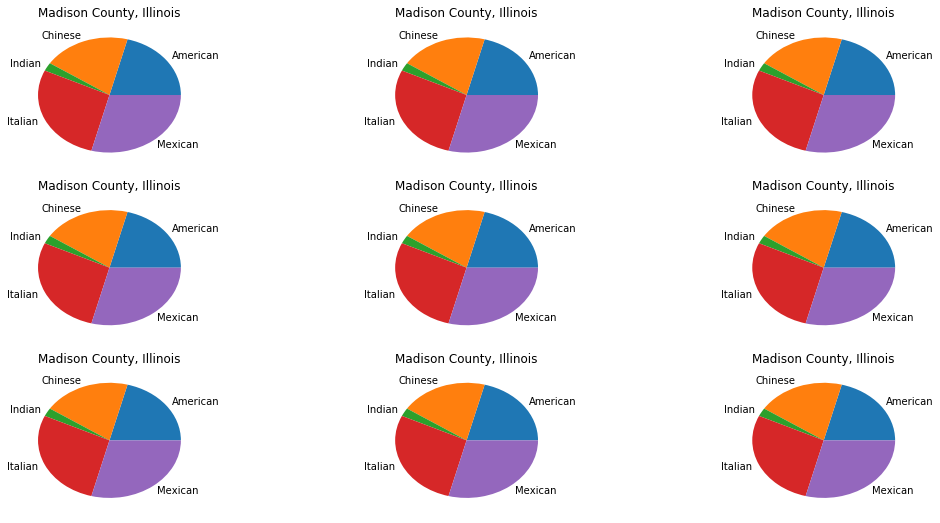

In [13]:
plt.show()

In [ ]:
comp = pd.DataFrame(res_df["category"].groupby(res_df["county_string"]).value_counts())
comp
#I HAVE NO IDEA WHAT TO DO WITH THIS

In [105]:
CHA = CHA["category"].value_counts().reset_index()
CHA["county_string"]="Mecklenburg County, North Carolina"
CHA.columns = ["category","count","county_string"]
CHA

NameError: name 'CHA' is not defined